# Exploratory Data Analysis

On original uncleaned filie

go to sa_hkuchatgpt/create_dataset.ipynb

On the dataset_cleaned_heartless.pkl file

In [1]:
# packages

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path

from collections import Counter
import re
import nltk
from nltk.corpus import stopwords

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


# plt style
plt.style.use('seaborn-v0_8-dark')

In [7]:
eda_graphs_path = Path('eda_graphs').resolve()
print(eda_graphs_path)

/Users/michaelcheng/Documents/MyDocs/HKU/COMP4801 FYP/FYP/NLP/dev-workspace/sa/eda_graphs


In [2]:
dataset_heartless_path = Path('../dataset/sa/dataset_cleaned_heartless_cleaned.pkl').resolve()

dataset = pd.read_pickle(dataset_heartless_path)
# dataset = dataset.sample(frac=p)      # no sampling is needed

# convert the text to string object
dataset['review_text'] = dataset['review_text'].astype('str')

# drop any duplicate just in case
dataset = dataset.drop_duplicates(keep='first')

We will see the ratio between positive and negative reviews

In [3]:
temp = dataset.groupby('review_score').count()['review_text'].reset_index().sort_values(by='review_score',ascending=True)
temp.style.background_gradient(cmap='Purples')

,review_score,review_text
0,0,753364
1,1,3873162


/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and

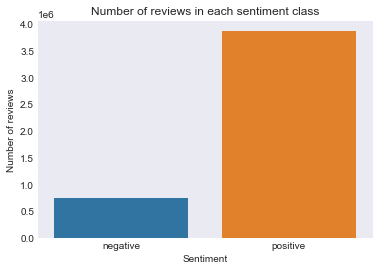

In [9]:
# plot a bar chart with seaborn

plt.style.use('seaborn-v0_8-dark')
ax = sns.barplot(temp, x=['negative','positive'], y='review_text')
ax.set_title('Number of reviews in each sentiment class')
ax.set(xlabel='Sentiment', ylabel='Number of reviews')
plt.show()

# save the plot
fig = ax.get_figure()
fig.savefig(Path.joinpath(eda_graphs_path, 'sentiment_distribution.png'), dpi=300)


In [10]:
print("Ratio between positive and negative comments: {:.8}".format(
    float(len(dataset[dataset['review_score'] == 1]) / len(dataset[dataset['review_score'] == 0]))
))

Ratio between positive and negative comments: 5.1411562


How about the distribution of length of reviews

In both positive and negative comments respectively

In [11]:
# first have all comments together

dataset['num_of_words'].describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

count    4.626526e+06
mean     6.523254e+01
std      1.098045e+02
min      1.000000e+00
1%       4.000000e+00
10%      7.000000e+00
25%      1.300000e+01
50%      2.900000e+01
75%      7.000000e+01
90%      1.550000e+02
99%      5.490000e+02
max      4.000000e+03
Name: num_of_words, dtype: float64

/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

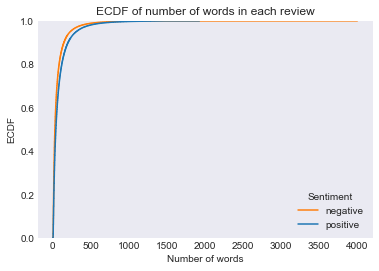

In [19]:
# plot ecdf (empirical cumulative distribution function) (or cumulative frequency graph)

ax = sns.ecdfplot(data=dataset, x='num_of_words', hue='review_score')
ax.set_title('ECDF of number of words in each review')
ax.set(xlabel='Number of words', ylabel='ECDF')

plt.legend(title='Sentiment', loc='lower right', labels=['Negative', 'Positive'])
plt.show()

# save the plot
fig = ax.get_figure()
fig.savefig(Path.joinpath(eda_graphs_path, 'ecdf_num_of_words.png'), dpi=300)

In [20]:
dataset_pos_only = dataset[dataset['review_score'] == 1]
dataset_neg_only = dataset[dataset['review_score'] == 0]

In [21]:
# describe the characteristics of the number of words

dataset_pos_only['num_of_words'].describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

count    3.873162e+06
mean     6.164262e+01
std      1.052375e+02
min      1.000000e+00
1%       4.000000e+00
10%      7.000000e+00
25%      1.200000e+01
50%      2.700000e+01
75%      6.600000e+01
90%      1.450000e+02
99%      5.250000e+02
max      4.000000e+03
Name: num_of_words, dtype: float64

/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='num_of_words', ylabel='Count'>

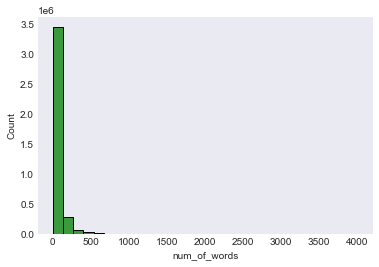

In [22]:
sns.histplot(data=dataset_pos_only, x='num_of_words',bins=30,color='green')

In [23]:
dataset_neg_only['num_of_words'].describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

count    753364.000000
mean         83.688866
std         129.225425
min           1.000000
1%            4.000000
10%           8.000000
25%          16.000000
50%          40.000000
75%          96.000000
90%         200.000000
99%         651.000000
max        1925.000000
Name: num_of_words, dtype: float64

/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='num_of_words', ylabel='Count'>

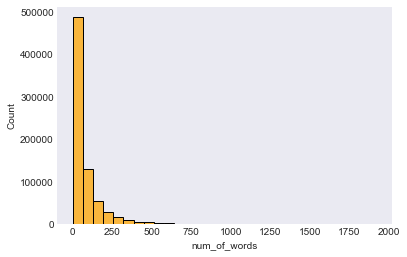

In [24]:
sns.histplot(data=dataset_neg_only, x='num_of_words',bins=30,color='orange')

The public dataset supports the distribution of the comments

- "Negative reviews are slightly longer than positive reviews, but the difference is negligible.". But seems the latter is not supported by the dataset we have.

- "Most games receive reviews with a median length of 205 characters, or 30 words.". The sentence is supported by the positive set and the overall dataset, but not on the negative set.

what if we remove comments less than 10 characters.

In [25]:
dataset_2 = dataset.copy()

number_of_charaters = 20

dataset_2 = dataset_2[dataset_2['review_text'].str.len()>=number_of_charaters]

In [26]:
# first have all comments together

dataset_2['num_of_words'].describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

count    4.626526e+06
mean     6.523254e+01
std      1.098045e+02
min      1.000000e+00
1%       4.000000e+00
10%      7.000000e+00
25%      1.300000e+01
50%      2.900000e+01
75%      7.000000e+01
90%      1.550000e+02
99%      5.490000e+02
max      4.000000e+03
Name: num_of_words, dtype: float64

In [27]:
dataset_2_pos_only = dataset_2[dataset_2['review_score'] == 1]
dataset_2_neg_only = dataset_2[dataset_2['review_score'] == 0]

In [28]:
# describe the characteristics of the number of words

dataset_2_pos_only['num_of_words'].describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

count    3.873162e+06
mean     6.164262e+01
std      1.052375e+02
min      1.000000e+00
1%       4.000000e+00
10%      7.000000e+00
25%      1.200000e+01
50%      2.700000e+01
75%      6.600000e+01
90%      1.450000e+02
99%      5.250000e+02
max      4.000000e+03
Name: num_of_words, dtype: float64

/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='num_of_words', ylabel='Count'>

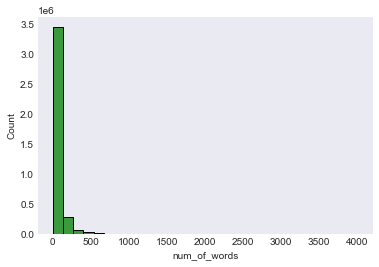

In [29]:
sns.histplot(data=dataset_2_pos_only, x='num_of_words',bins=30,color='green')

In [30]:
dataset_2_neg_only['num_of_words'].describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

count    753364.000000
mean         83.688866
std         129.225425
min           1.000000
1%            4.000000
10%           8.000000
25%          16.000000
50%          40.000000
75%          96.000000
90%         200.000000
99%         651.000000
max        1925.000000
Name: num_of_words, dtype: float64

In [31]:
# select some text for sample

dataset_2_neg_only[dataset_2_neg_only['num_of_words']==645].iloc[0]['review_text']

"After I bought Postal 2, i saw that there was a third one and it had modern-day graphics and i thought that was pretty cool and then I saw all the negative reviews except for the literally only postive review and i thought to myself, hmmm I wonder how bad this game is? Seeing as how the second one was badass and amazingly better than some of the AAA games we get served today, so i bought it, played it and beat it, and now i now why this game is slandered, even RWS has given up on this trainwreck but before i trash this game more i have to say there are parts of this game that are good but far from being awesome.  Like my review of Postal 2, this review will broken down in the same areas  Gameplay, Graphics, Sound and most importantly Story  Warning: this is my opinon and if anything offends you, i deeply apolgize  Gameplay 5/10: the overall gmeplay isn't all to bad, the controls aren't bad but they are a big difference from its predecessor, the main control feature i like about this g

In [32]:
for index, row in dataset_2_pos_only[dataset_2_pos_only['num_of_words'] > 512].sample(n=5).iterrows():
    print("\""+ row['review_text']+ "\",")
    print()

"When I first played Killing Floor, I didn't really enjoy it. I found (and still find) the game's visuals deperssing. Although the game's architecture is highly detailed, the enemies all have a morbid appearance, and the environments are anything but uplifting. (In many of the maps, your vision is impaired by smog or darkness.)  I generally dislike FPS games where enemies attack in waves, preferring the old school kind which encourages and rewards exploration and clearing out sections of maps. In any case, I figured I ought to play some more to see if I was simply missing out on something that so many other seem to like about the game.  I took the game online, and found that a lot of the online community is either indifferent to co-operation or sometimes hostile to it. The game's difficulty adapts to the number of players actively playing, so needless to say, that experience didn't improve my outlook on the game.  It wasn't until I began to experiment with many different character clas

In [33]:
for index, row in dataset_2_neg_only[dataset_2_neg_only['num_of_words'] > 512].sample(n=5).iterrows():
    print("\""+ row['review_text']+ "\",")
    print()

"Flix the Flea is a two button platformer where we play as some kind of mutant flea that snuck on-board into a space shuttle and is brought to space. If you were to skip the opening you would have no way of knowing you are in space as there are pterodactyls, bats and even trees. Granted it does take place in caves but why mention we are in space then? Nothing really makes sense which is not a bad thing but you see all this game has to offer in the first mission. Each level feels very similar even though they are visually different. There is a life system and if you lose all of them it is back to the beginning of the game.  The only way to lose your life is if you touch a pterodactyl that flies around the stage. It is a lot easier said than done as the screen is far too zoomed in and everytime you jump you will have no idea what lies ahead. Most of the time that leads to you following down all the way to the bottom since pterodactyls do have a huge arrow pointing at their location when 

/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='num_of_words', ylabel='Count'>

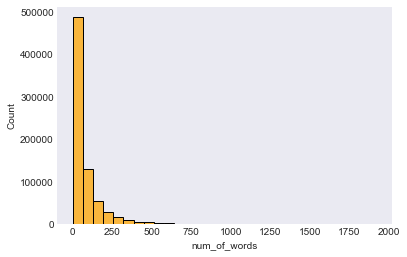

In [34]:
sns.histplot(data=dataset_2_neg_only, x='num_of_words',bins=30,color='orange')

Distribution of words in all review texts

We will perform that with stopwords and w/out stopwords

In [35]:
dataset['list_words'] = dataset['review_text'].apply(lambda x:str(x).split())

In [36]:
top = Counter([item for sublist in dataset['list_words'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,the,11962640
1,and,8059396
2,a,7575440
3,to,7517241
4,of,5799862
5,is,5363136
6,game,4980906
7,I,4880257
8,you,4550395
9,it,3712634


In [37]:
# create a dataset with cleaning performed

dataset_cleaned = dataset.copy(deep=True)

In [38]:
# clean basic characters
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result

In [39]:
# remove numerics (maybe not required in BERT)
def remove_num(texts):
   output = re.sub(r'\d+', '', texts)
   return output

In [40]:
# remove emojis
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

In [41]:
def unify_whitespaces(x):
    cleaned_string = re.sub(' +', ' ', x)
    return cleaned_string 

In [42]:
# remove special symbols
def remove_symbols(x):
    cleaned_string = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', x)
    return cleaned_string

In [43]:
# remove punctuation (just for analysis, maybe not required in BERT)
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',','))
    return final

### remove stopwords

Stopwords are words that occur frequently in a language and are often grammatical in nature, such as articles (e.g., "the," "a"), prepositions (e.g., "in," "on"), conjunctions (e.g., "and," "but"), and pronouns (e.g., "he," "she"). These words are necessary for constructing sentences and conveying grammatical structure, but they often do not contribute much to the overall meaning of the text.

- noise reduction
- Improved Analysis Accuracy
- faster processing

In [44]:
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer

stop=set(stopwords.words("english"))
stemmer=PorterStemmer()
lemma=WordNetLemmatizer()

def remove_stopword(text):
   text=[word.lower() for word in text.split() if word.lower() not in stop]
   return " ".join(text)

### use stemming to normalize words

Reduce the words to its stem to reduce dimension.
e.g. 

cared ----> care

university ----> univers

fairly ----> fair

easily ----> easili

singing ----> sing

sings ----> sing

sung ----> sung

singer ----> singer

sportingly ----> sport

In [45]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
def stemming(text):
   stem=[]
   # stopword = stopwords.words('english')
   snowball_stemmer = SnowballStemmer('english')
   word_tokens = nltk.word_tokenize(text)
   stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
   stem=' '.join(stemmed_word)
   return stem

In [46]:
import str_cleaning_functions

# func definition see above, also in the str_cleaning_functions.py file

def cleaning(df,review):
    df[review] = df[review].apply(str_cleaning_functions.clean)
    df[review] = df[review].apply(str_cleaning_functions.deEmojify)
    df[review] = df[review].str.lower()
    df[review] = df[review].apply(str_cleaning_functions.remove_num)
    df[review] = df[review].apply(str_cleaning_functions.remove_symbols)
    df[review] = df[review].apply(str_cleaning_functions.remove_punctuation)
    df[review] = df[review].apply(str_cleaning_functions.remove_stopword)
    df[review] = df[review].apply(str_cleaning_functions.unify_whitespaces)
    df[review] = df[review].apply(str_cleaning_functions.stemming)

In [47]:
cleaning(dataset_cleaned,'review_text')

In [48]:
dataset_cleaned['list_words'] = dataset_cleaned['review_text'].apply(lambda x:str(x).split())

In [49]:
top2 = Counter([item for sublist in dataset_cleaned['list_words'] for item in sublist])
temp2 = pd.DataFrame(top2.most_common(20))
temp2.columns = ['Common_words','count']
temp2.style.background_gradient(cmap='Blues')

,Common_words,count
0,game,8323674
1,play,2436824
2,like,1684616
3,get,1409738
4,one,1190300
5,good,1153401
6,time,1119516
7,fun,1115395
8,great,986062
9,realli,969311


/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='count', ylabel='Common_words'>

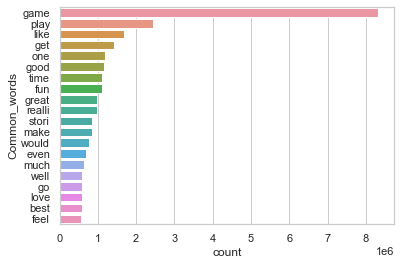

In [50]:
sns.set_theme(style="whitegrid")
sns.barplot(x="count", y="Common_words", data=temp2)

In [51]:
len(Counter({k:c for k,c in top2.items() if c >= 1000}))

6413

In [52]:
# find top 5000 ?

top2.most_common(7000)[-30:]

[('optimist', 836),
 ('intervent', 835),
 ('buffer', 835),
 ('herb', 835),
 ('swedish', 835),
 ('ritual', 835),
 ('python', 834),
 ('approx', 834),
 ('copyright', 833),
 ('undetect', 833),
 ('wand', 833),
 ('iam', 832),
 ('ctf', 832),
 ('gunshot', 832),
 ('perceiv', 832),
 ('pov', 832),
 ('louder', 832),
 ('eido', 832),
 ('intersect', 831),
 ('coincid', 830),
 ('pase', 830),
 ('whop', 830),
 ('ko', 830),
 ('vergil', 830),
 ('unintent', 829),
 ('pr', 829),
 ('psyonix', 829),
 ('literali', 828),
 ('laura', 828),
 ('predetermin', 828)]

If we break into positive and negative comments...

In [53]:
dataset_cleaned_pos_only = dataset_cleaned[dataset_cleaned['review_score'] == 1]
dataset_cleaned_neg_only = dataset_cleaned[dataset_cleaned['review_score'] == 0]

In [54]:
top3 = Counter([item for sublist in dataset_cleaned_pos_only['list_words'] for item in sublist])
temp3 = pd.DataFrame(top3.most_common(20))
temp3.columns = ['Common_words','count']
temp3.style.background_gradient(cmap='Blues')

,Common_words,count
0,game,6717449
1,play,2003455
2,like,1348067
3,get,1095421
4,one,989361
5,fun,984819
6,good,978059
7,great,903207
8,time,882286
9,realli,779545


/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='count', ylabel='Common_words'>

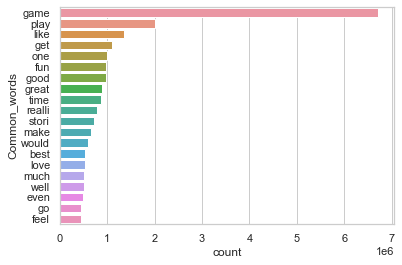

In [55]:
sns.set_theme(style="whitegrid")
sns.barplot(x="count", y="Common_words", data=temp3)

In [56]:
top4 = Counter([item for sublist in dataset_cleaned_neg_only['list_words'] for item in sublist])
temp4 = pd.DataFrame(top4.most_common(20))
temp4.columns = ['Common_words','count']
temp4.style.background_gradient(cmap='Blues')

,Common_words,count
0,game,1606225
1,play,433369
2,like,336549
3,get,314317
4,time,237230
5,even,206310
6,one,200939
7,realli,189766
8,good,175342
9,make,172662


/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='count', ylabel='Common_words'>

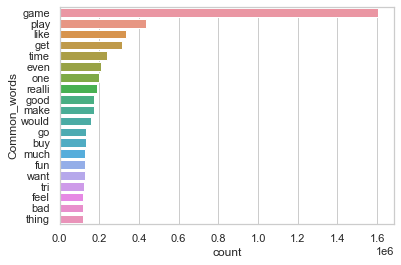

In [57]:
sns.set_theme(style="whitegrid")
sns.barplot(x="count", y="Common_words", data=temp4)

what are the common words appeared in both top 20?

In [58]:
temp5 = pd.merge(temp3,temp4, how='inner', on=['Common_words'])

In [59]:
temp5

,Common_words,count_x,count_y
0,game,6717449,1606225
1,play,2003455,433369
2,like,1348067,336549
3,get,1095421,314317
4,one,989361,200939
5,fun,984819,130576
6,good,978059,175342
7,time,882286,237230
8,realli,779545,189766
9,make,662531,172662


looks almost the same as the overall dataset, as the positive comments are very domainant...

Wordcloud generation (on whole dataset)

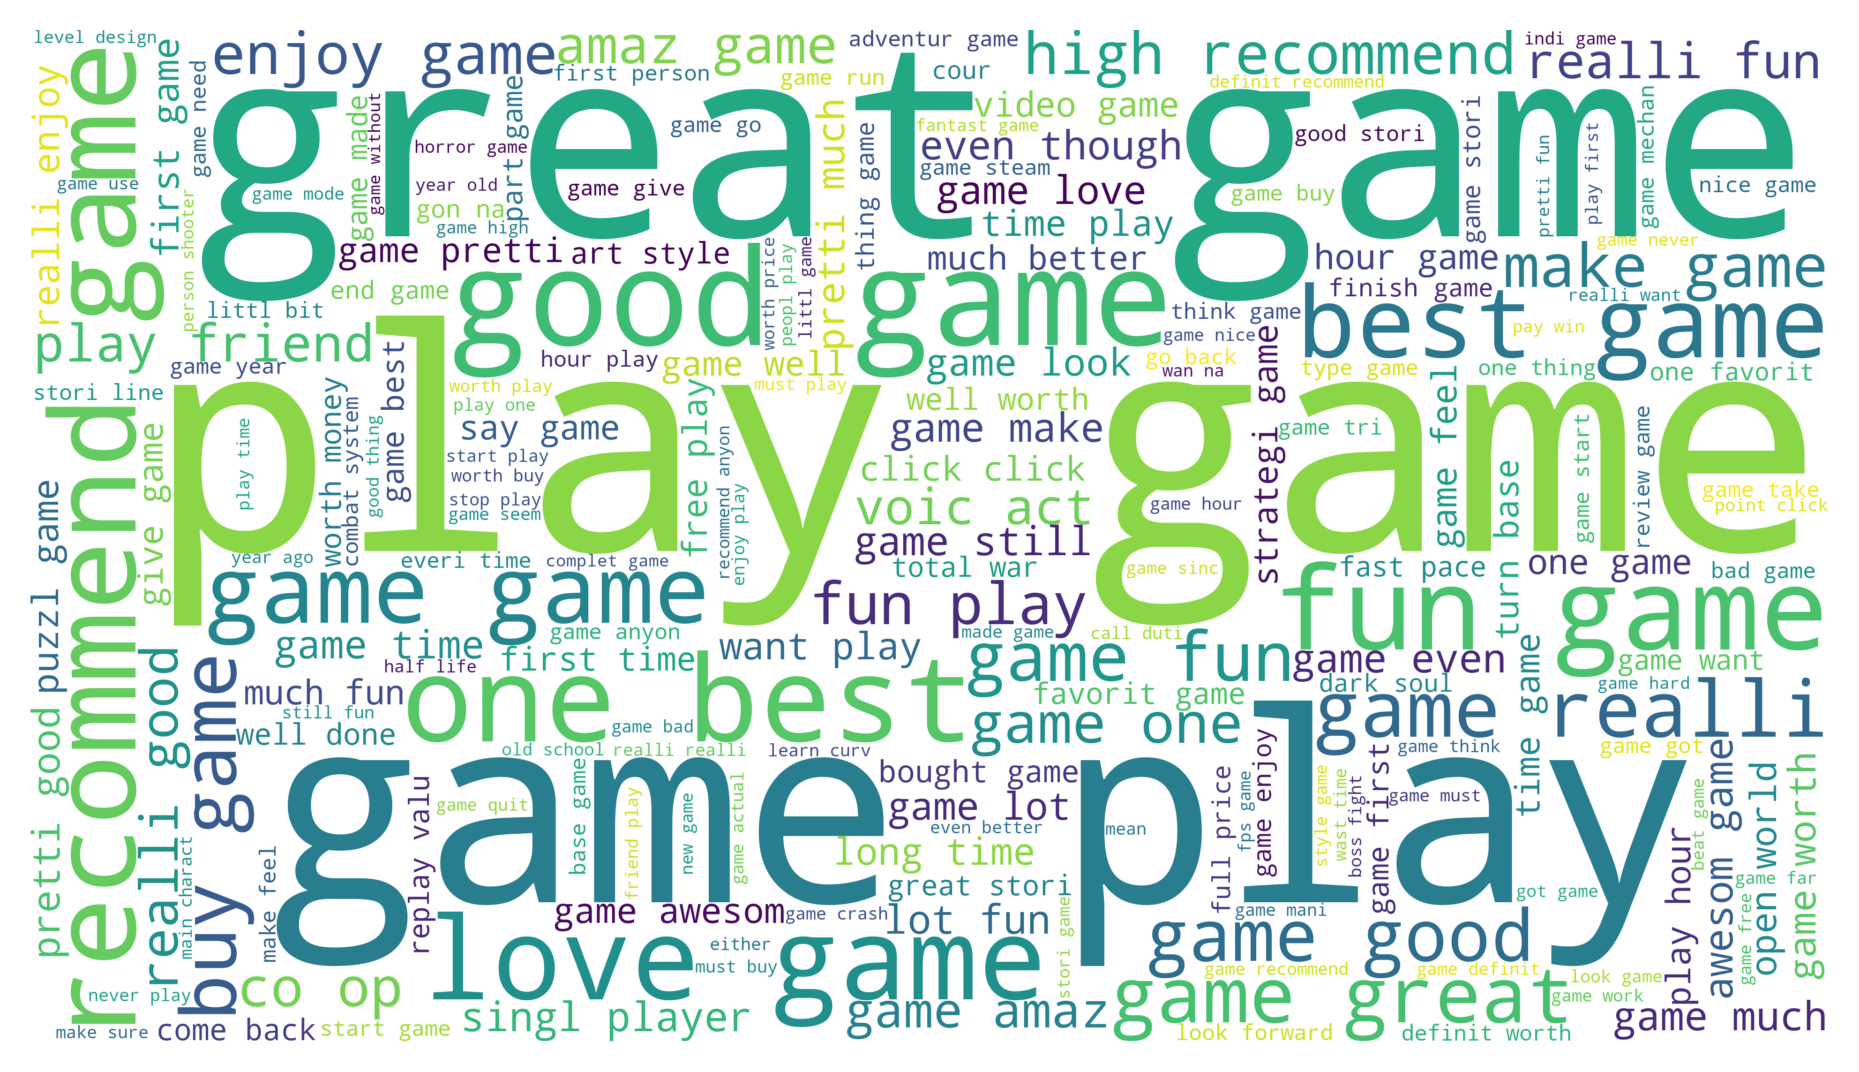

<Figure size 432x288 with 0 Axes>

In [72]:
txt_wholedataset = ' '.join(t for t in dataset_cleaned['review_text'])
plt.figure(dpi=300)

wordcloud = WordCloud(
    max_words=200,
    width=3840,
    height=2160,
    background_color="white"
    ).generate(txt_wholedataset)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# save plot

plt.savefig(Path.joinpath(eda_graphs_path, 'wordcloud_wholedataset.png'), dpi=300, bbox_inches='tight')

In [76]:
# save the wordcloud as png
with open(Path.joinpath(eda_graphs_path, 'wordcloud_wholedataset.svg'), 'w') as f:
    f.write(wordcloud.to_svg())

wordcloud.to_file(Path.joinpath(eda_graphs_path, 'wordcloud_wholedataset.png'))

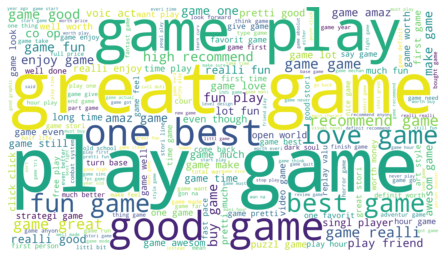

In [74]:
# plot for positive reviews

txt_pos = ' '.join(t for t in dataset_cleaned_pos_only['review_text'])

wordcloud_pos = WordCloud(
    max_words=200,
    width=3840,
    height=2160,
    background_color="white"
    ).generate(txt_pos)

plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# save plot
# plt.savefig(Path.joinpath(eda_graphs_path, 'wordcloud_pos.png'), dpi=300, bbox_inches='tight')

with open(Path.joinpath(eda_graphs_path, 'wordcloud_pos.svg'), 'w') as f:
    f.write(wordcloud_pos.to_svg())
wordcloud_pos.to_file(Path.joinpath(eda_graphs_path, 'wordcloud_pos.png'))

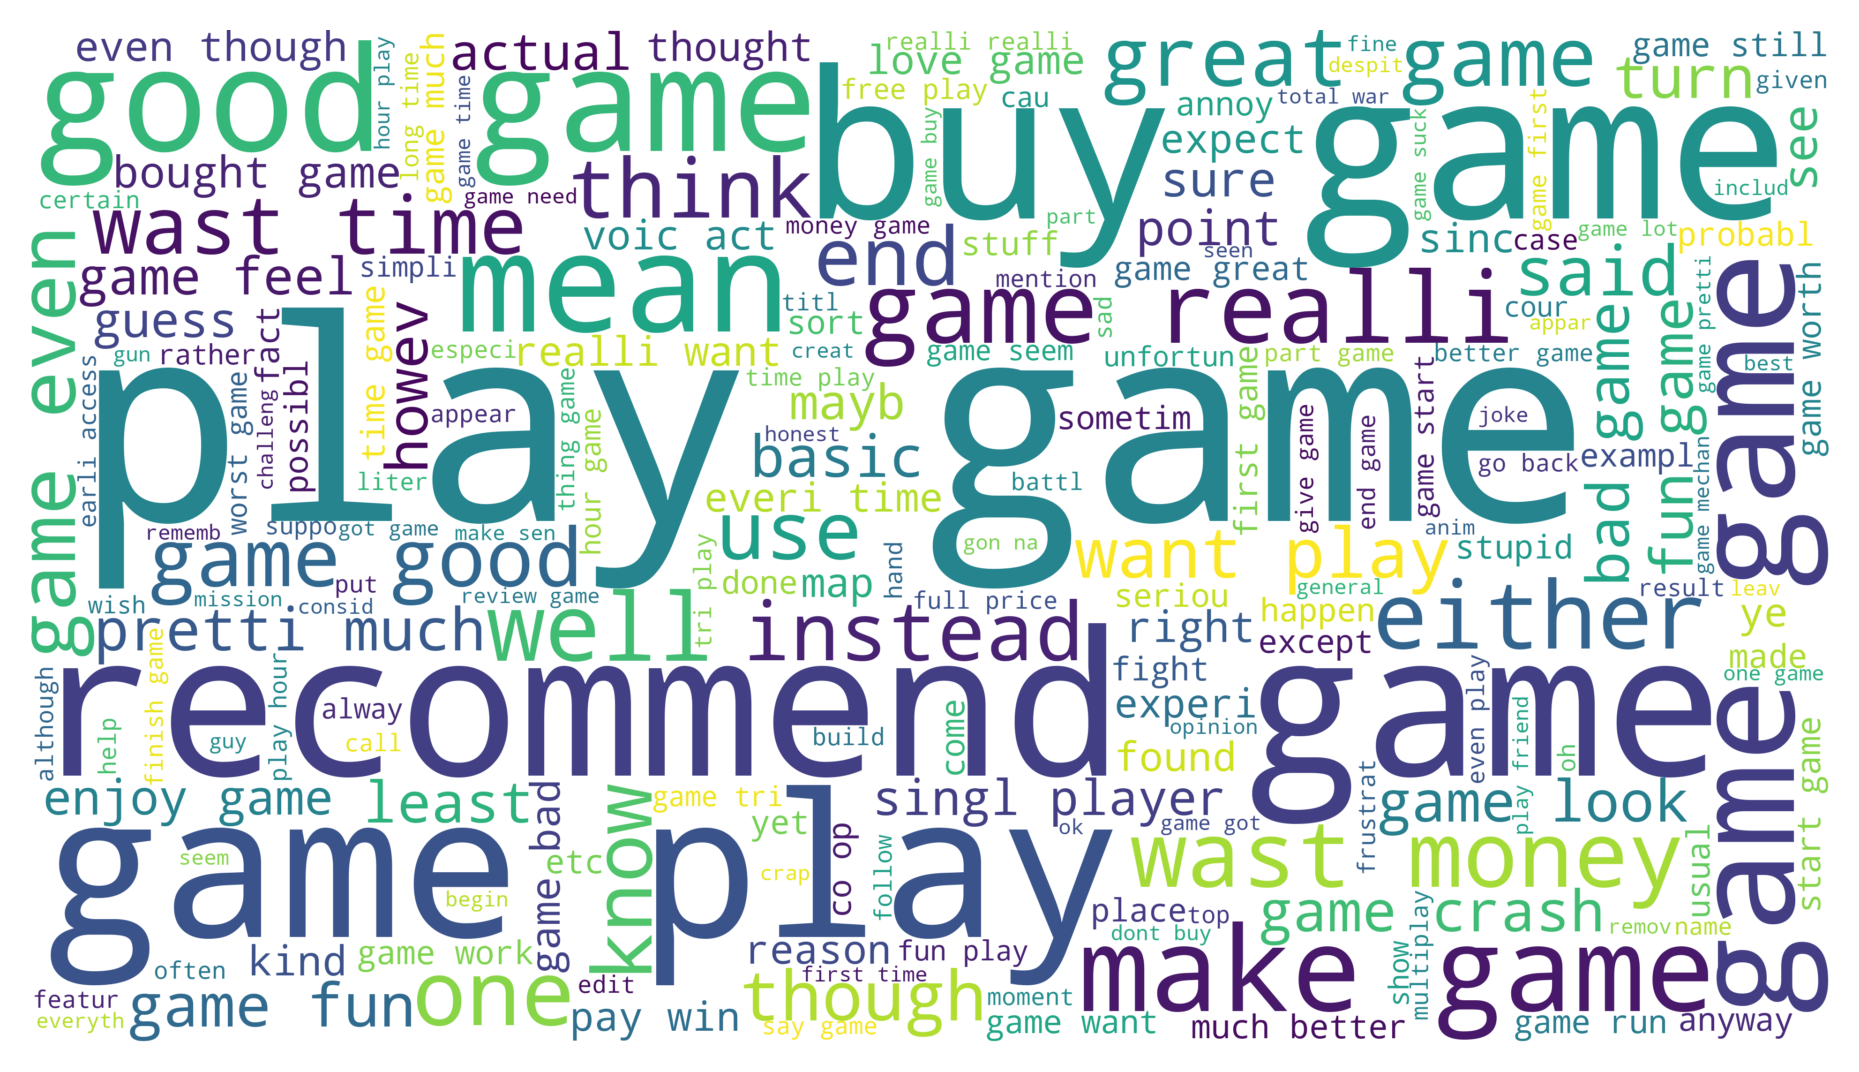

In [75]:
# plot for negative reviews

txt_neg = ' '.join(t for t in dataset_cleaned_neg_only['review_text'])
plt.figure(dpi=300)

wordcloud_neg = WordCloud(
    max_words=200,
    width=3840,
    height=2160,
    background_color="white"
    ).generate(txt_neg)

plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# save plot
with open(Path.joinpath(eda_graphs_path, 'wordcloud_neg.svg'), 'w') as f:
    f.write(wordcloud_neg.to_svg())
wordcloud_neg.to_file(Path.joinpath(eda_graphs_path, 'wordcloud_neg.png'))

Due to hardware limitation, we will create a balanced dataset by randomly sampling positive comments in training

There are different methods in randomly selecting samples, yet the difference in performance are not significant (~0.01 in accuracy)  
E.g.: https://ruslanmv.com/blog/How-to-handle-imbalanced-text-data-in-Natural-Language-Processing

The undersampler in imbalanced-learning package will be applied on the training set

Then we may scrap new comments for validation on recent comments :D